# Privacy analysis

Randomized response on some of the columns of the data in order to hide sensitive information about individuals.

treatment_data: 
* Comorbilities 
* Gender
* Death
* Age (LM)

outcome_data:
* Death

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import random
random.seed(10)

In [2]:
#importing the data and titling the columns:
treat_data = pd.read_csv("treatment_features.csv",header=None)
action_data = pd.read_csv("treatment_actions.csv",header=None)
outcome_data = pd.read_csv("treatment_outcomes.csv",header=None)

symptoms_names = ['Covid-Recovered', 'Covid-Positive', 'No-Taste-Smell', 'Fever', 'Headache', 
                  'Pneumonia', 'Stomach', 'Myocarditis', 'Blood-Clots', 'Death','Age', 'Gender', 'Income']
cols = ( symptoms_names +
         [f'Gene_{i+1:03}' for i in range(128)] +
         ['Asthma', 'Obesity', 'Smoking', 'Diabetes', 'Heart disease', 'Hypertension',
         'Vacc_1', 'Vacc_2', 'Vacc_3'])

treat_data.columns = cols
outcome_data.columns = cols[:10]
action_data.columns = ['Treatment_1', 'Treatment_2']

In [3]:
#removing the bias variable "income"
treat_data = treat_data.drop('Income', axis=1)

In [4]:
#randomized response
def randomize(a, theta):
    flip = np.random.choice([True, False], p=(theta, (1-theta)), size=a.shape)
    noise = np.random.choice([0, 1], size=a.shape)
    response = np.array(a)
    response[~flip] = noise[~flip]
    return response

In [5]:
def get_randmized_data(p_var,p_y):
    #randomized response for treatment_data
    new_treat_data = treat_data.copy()

    for variable in p_var:
        new_treat_data[variable] = randomize(new_treat_data[variable],p_var[variable])

    #randomized response for outcome_data
    new_outcome_data = outcome_data.copy()
    new_outcome_data['Death'] = randomize(new_outcome_data['Death'],p_y)
    
    return new_treat_data,new_outcome_data

In [6]:
# approx. original p
def approx_p(sample, theta):
    return randomize(sample, theta).mean() / theta - (1 - theta) / 2 / theta

In [153]:
def show_hists(data, theta,s):
    approx = [approx_p(data, theta) for _ in range(data.shape[0])]
    true_v = [data.sample(data.shape[0],replace=True).mean() for _ in range(data.shape[0])]
    
    plt.hist(approx, bins=100, alpha=0.5, label='noisy')
    plt.hist(true_v, bins=100, alpha=0.5, label='true')
    plt.legend()
    plt.title(f'theta = {theta}')
    plt.ylabel('Frequency')
    plt.xlabel(f'Average {s}')
    plt.savefig(f'/Users/roaka001/Documents/OneDrive/IN-STK5000/fairness_and_privacy/figs_privacy/{s}-noise')
    plt.figure()

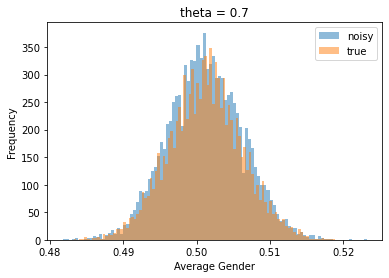

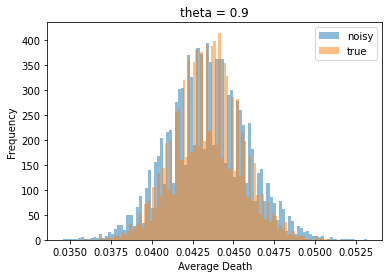

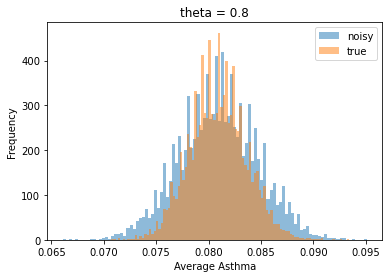

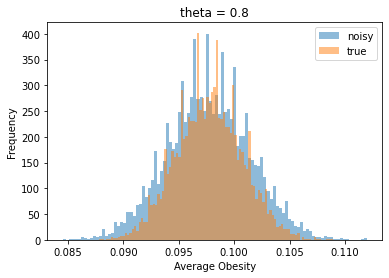

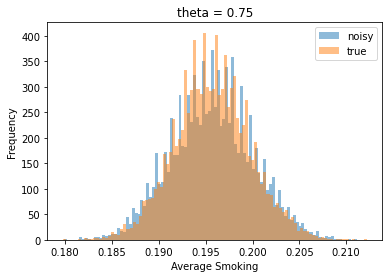

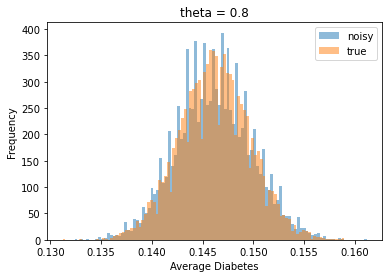

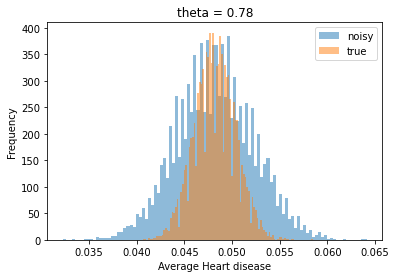

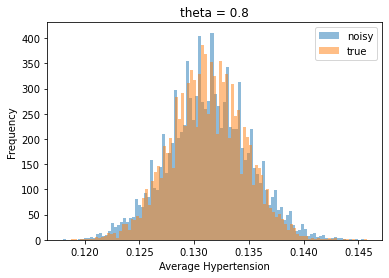

<Figure size 432x288 with 0 Axes>

In [16]:
p_variables = {'Gender':0.7,'Death':0.9,'Asthma':0.8, 'Obesity':0.8, 'Smoking':0.75, 'Diabetes':0.8, 'Heart disease':0.78, 'Hypertension':0.8}
new_treat_data,new_outcome_data = get_randmized_data(p_variables,0.8)
for var in p_variables:
    show_hists(treat_data[var],p_variables[var],var)

The histogram for outcome data:

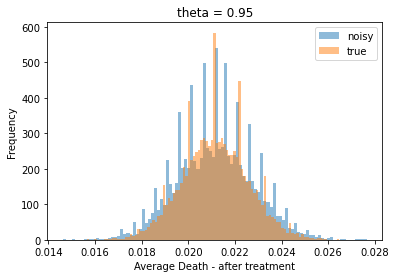

<Figure size 432x288 with 0 Axes>

In [15]:
show_hists(outcome_data['Death'],0.95,'Death - after treatment')

## Laplace mechanism

treat_data:
* Age

In [17]:
new_treat_data = treat_data.copy()
sensitivity = 1/(np.max(new_treat_data['Age']))
epsilon = 0.1

new_treat_data['Age'] = new_treat_data['Age'] + np.random.laplace(0, sensitivity/epsilon,size=new_treat_data.shape[0])
all(new_treat_data['Age']>0)

True

# Computing the accuracy

In [80]:
def get_probs(X,Y):
    probs = []
    
    X_tr, X_ts, Y_tr,Y_ts = train_test_split(X,Y,test_size=0.33,random_state=1) 
    for i in range(Y_tr.shape[1]-2):
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_tr,Y_tr.iloc[:,i+2])

        #predicitng
        probs.append(clf.predict_proba(X_ts))
        #yhat = clf.predict(X_ts)
        #acc = clf.score(X_ts,Y_ts.iloc[:,i+2])
        #probs.append(acc)
    return np.array([np.mean(y) for y in probs])

## Change in utility as $\theta$ varies

In [155]:
def get_utility(features, action, outcome):
    np.random.seed(10)
    rewards = np.zeros(10)
    weights = np.zeros(10)
    
    if len(features.shape) == len(action.shape) == len(outcome.shape) == 1:
        if 0 < features['Age'] <= 30: #young
            weights = 10*np.array([0,0,0.1,0.1,0.1,0.5,0.2,0.5,1.0,100])
        elif 30 < features['Age'] <= 60: #middel age
            weights = 10*np.array([0,0,0.2,0.2,0.2,0.7,0.4,0.7,2.0,90])
        else: #old
            weights = 10*np.array([0,0,0.5,0.5,0.5,1.2,0.5,1.0,10.0,70])

        rewards -= weights*outcome + np.random.uniform()
        return rewards

    np.random.seed(10)
    action_cost = np.random.uniform(0.5,1.5, size = action.shape[1])
    
    for i in range(features.shape[0]):
        if features['Age'].min() < features['Age'].iloc[i] <= 30: #young
            weights = 10*np.array([0,0,0.1,0.1,0.1,0.5,0.2,0.5,1.0,100])
        elif 30 < features['Age'].iloc[i] <= 60: #middel age
            weights = 10*np.array([0,0,0.2,0.2,0.2,0.7,0.4,0.7,2.0,90])
        else: #old
            weights = 10*np.array([0,0,0.5,0.5,0.5,1.2,0.5,1.0,4.0,70])
        
        cost = 0
        for j in range(action.shape[1]):
            if action.iloc[i,j] == 1:
                cost += action_cost[j]

        rewards -= weights*outcome.iloc[i] + cost
    
    return rewards

In [156]:
def compute_utility(X,action_data,y):
    u = 0
    for i in range (X.shape[0]):
        u += get_utility(X.iloc[i],action_data.iloc[i],y.iloc[i])[1]
        
    return u

## Generating randomized data with different $\theta$, then finding the loss in expected utility

In [157]:
u_original = get_utility(treat_data,action_data,outcome_data)
y_proba = get_probs(treat_data,outcome_data)
expected_utility = y_proba.T @ u_original[2:]

In [158]:
def find_loss(theta):
    p_variables = {'Gender':theta,'Death':theta,'Asthma':theta, 'Obesity':theta, 'Smoking':theta, 'Diabetes':theta, 'Heart disease':theta, 'Hypertension':theta}
    new_treat_data,new_outcome_data = get_randmized_data(p_variables,theta)
    
    u_ = get_utility(new_treat_data,action_data,new_outcome_data)
    y_proba_ = get_probs(new_treat_data,new_outcome_data)

    expected_u = y_proba_.T @ u_[2:]
    return abs(expected_utility - expected_u)

In [159]:
for i in np.linspace(0.5,0.99,11):
    print(f'Theta = {i:3.3f} |epsilon = {np.log((1-(1-i))/(1-i)):3.3f}| loss: {find_loss(i):3.3f} ')

Theta = 0.500 |epsilon = 0.000| loss: 1140600.000 
Theta = 0.549 |epsilon = 0.197| loss: 1031600.000 
Theta = 0.598 |epsilon = 0.397| loss: 910200.000 
Theta = 0.647 |epsilon = 0.606| loss: 807300.000 
Theta = 0.696 |epsilon = 0.828| loss: 693600.000 
Theta = 0.745 |epsilon = 1.072| loss: 569400.000 
Theta = 0.794 |epsilon = 1.349| loss: 470850.000 
Theta = 0.843 |epsilon = 1.681| loss: 365500.000 
Theta = 0.892 |epsilon = 2.111| loss: 250900.000 
Theta = 0.941 |epsilon = 2.769| loss: 147250.000 
Theta = 0.990 |epsilon = 4.595| loss: 26950.000 
